# Solution Graded Exercise 2: Hodgkin-Huxley model

first name: ...

last name: ...

sciper: ...

date: ...

*Your teammate*

first name of your teammate: ...

last name of your teammate: ...

sciper of your teammate: ...


Note: You are allowed to discuss the concepts with your class mates. You are not allowed to share code. You have to understand every line of code you write in this notebook. We will ask you questions about your submission during a fraud detection session during the last week of the semester.


** Submission **

Rename this notebook to Ex6_FirstName_LastName_Sciper.ipynb and upload that single file on moodle before the deadline.

** Link to the exercise **

http://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hodgkin-huxley.html

** Note **
We have updated question 6.2 of the online exercise. If you have already started with this exercise in week 2, make sure you check the latest version here: http://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hodgkin-huxley.html. 

# Exercise 6, getting started

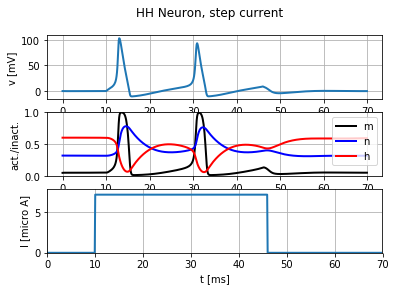

In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex.hodgkin_huxley import HH
from neurodynex.tools import input_factory

HH.getting_started()

## 6.1. Exercise: step current response

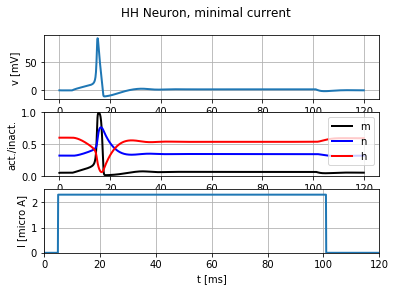

In [2]:
I_min = 2.3
current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

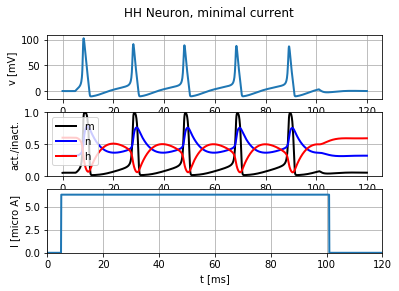

In [3]:
I_min = 6.3
current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")


## 6.2. Exercise: slow and fast ramp current

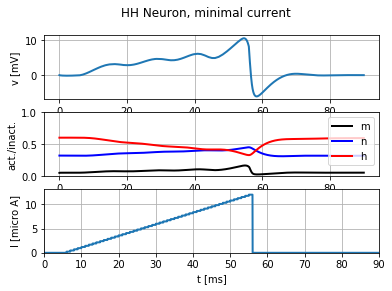

voltage_slow=10.36250878 mV


In [31]:
b2.defaultclock.dt = 0.02*b2.ms
slow_ramp_t_end = 55  # no spike. make it shorter
slow_ramp_current = input_factory.get_ramp_current(5, slow_ramp_t_end, b2.ms, 0.*b2.uA, 12.0*b2.uA)
state_monitor = HH.simulate_HH_neuron(slow_ramp_current, 90 * b2.ms)
idx_t_end = int(round(slow_ramp_t_end*b2.ms / b2.defaultclock.dt))
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

voltage_slow = state_monitor.vm[0,idx_t_end]
print("voltage_slow={}".format(voltage_slow))

voltage_fast=6.20703567 mV


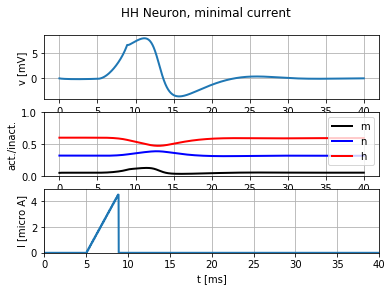

In [38]:
b2.defaultclock.dt = 0.02*b2.ms
fast_ramp_t_end = 88  # no spike. make it longer
fast_ramp_current = input_factory.get_ramp_current(50, fast_ramp_t_end, 0.1*b2.ms, 0.*b2.uA, 4.5*b2.uA)
state_monitor = HH.simulate_HH_neuron(fast_ramp_current, 40 * b2.ms)
idx_t_end = int(round(fast_ramp_t_end*0.1*b2.ms / b2.defaultclock.dt))
voltage_fast = state_monitor.vm[0,idx_t_end]
print("voltage_fast={}".format(voltage_fast))
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

## 6.3 Rebound Spike

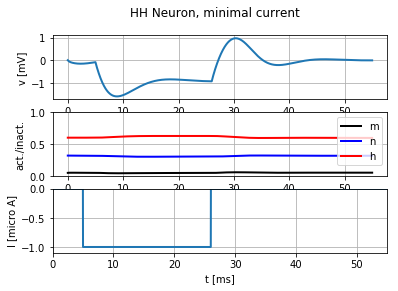

In [40]:
I_min = -1
current = input_factory.get_step_current(5, 25, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 55 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

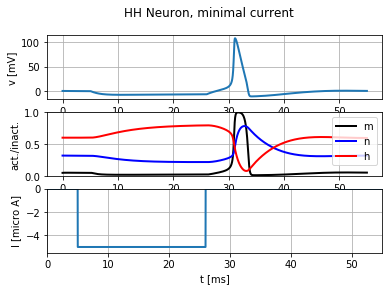

In [41]:
I_min = -5
current = input_factory.get_step_current(5, 25, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 55 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

## 6.4 modified HH implementation

In [54]:
def tampered_HH_neuron(input_current, simulation_time):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = 10.6 * b2.mV
    EK = -12 * b2.mV
    ENa = 115 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = 5.4 * 120 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)
    
    return st_mon


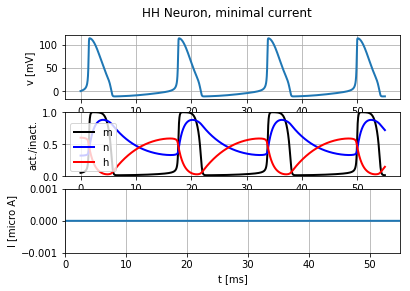

In [55]:
current = input_factory.get_step_current(5, 25, b2.ms, 0. *b2.uA)
state_monitor = tampered_HH_neuron(current, 55 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

## 6.5 Reduction to two dimensions: the Morris-Lecar model
This exercise is not available online. All information is given here.


* Implement Morris-Lecar (Box in chapter 4.2 of the book: http://neuronaldynamics.epfl.ch/online/Ch4.S2.html). We give you the correct parameters for the model. If you are unsure of how to implement the dynamics in Brian2, compare with the implementation of the HH model:
http://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex/hodgkin_huxley/HH.html#simulate_HH_neuron

* Complete the function plot_state_vars below.

    * Stimulate your Morris-Lecar  neuron with a step current  (130 uAmp for 10ms).  
    * The spike you observe is delayed with  respect to the current onset, then it raises very quickly. Discuss which parameters drive each of the two regimes  and which part of the model is responsible for the transition between the two regimes.

*  On paper, derive the u and w_hat nullclines (w_hat, not w!). Then  insert them into the function get_v_w_nullclines below. 
*  Stimulate  your neuron with  longer current such that you get repetitive firing.  
    *  Plot the response of the system with  plot_state_vars, as you did before
    *  The function plot_phase_plane is given below. Use it to plot the trajectory in the phase plane.
    *  Discuss the phase plane
    



In [ ]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex.hodgkin_huxley import HH
from neurodynex.tools import input_factory
from neurodynex.tools import plot_tools

# neuron parameters
EL = -60. * b2.mV
E1 = +60. * b2.mV
E2 = -84. * b2.mV

gL = 2.0 * b2.msiemens
g2 = 8.0 * b2.msiemens
g1 = 9. * b2.msiemens

C = 5. * b2.ufarad

u1 = -1.2*b2.mV
u2 = 18.0*b2.mV
u3 = 7.0*b2.mV
u4 = 10.0*b2.mV

tau_w = 30 * b2.ms

def simulate_MorrisLecar_neuron(input_current, simulation_time):

    # Write the dynamical equations for the neuron model. Make sure you use the variable
    # name "v" for the membrane voltage and "w" for w_hat.
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m*(ENa-vm) + \
        gl*(El-v) + gK*w*(EK-v) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dn/dt = alphan*(1-n)-betan*n : 1
    dv/dt = membrane_Im/C : volt
    """


    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.v = EL

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["v", "w", ???], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

def plot_state_vars(state_monitor, title=None):
    #     make three subplots:
    #     1: voltage vs. time
    #     2: m0, w0, w_hat vs. time
    #     3: injection current vs. time

    #     copy the function plot_data from the module neurodynex.hodgkin_huxley.HH and change it accordingly:
    #     http://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex/hodgkin_huxley/HH.html

def get_v_w_nullclines(u_values, EL, E1, E2, gL, g2, g1, u1, u2, u3, u4, current_amplitude):
    v_nullcline = ???
    w_nullcline = ???
    return v_nullcline, w_nullcline


def plot_phase_plane(state_monitor, u_values, v_nullcline, w_nullcline):
    def plt_point_by_index(idx, symb, lbl):
        # helper to plot start and end point of trajectory
        v_i = state_monitor.v[0, idx]/ b2.mV
        w_i = state_monitor.w[0, idx]
        plt.plot(v_i, w_i, symb, label = lbl)
        
    plt.plot(u_values/ b2.mV, v_nullcline, 'm-', lw=2, label='u-nullcline')
    plt.plot(u_values/ b2.mV, w_nullcline, 'g-', lw=2, label='w_hat-nullcline')
    plt.scatter(state_monitor.v[0] / b2.mV, state_monitor.w[0], s=5, color='blue', label="trajectory")
    plt_point_by_index(0, "or", "start")
    plt_point_by_index(len(state_monitor.v[0])-1, "oc", "end")
    plt.legend(loc='best')
    plt.grid()
    plt.ylim([-0.1,1.6])
    plt.xlabel("u [mV]")
    plt.ylabel("w hat")
    plt.title("Phase plane for the Morris-Lecar model")

u_values = np.arange(-80, 60.0, 2.0)*b2.mV
v_nullcline, w_nullcline = get_v_w_nullclines(u_values, EL, E1, E2, gL, g2, g1, u1, u2, u3, u4, current_amplitude)

# inject a current, simulate, discuss
current = ???
state_monitor = simulate_MorrisLecar_neuron(current, ??? * b2.ms)
plot_state_vars(state_monitor)
plot_phase_plane(state_monitor, u_values, v_nullcline, w_nullcline)
